In [1]:
# Importing Libraries
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# Loading Data
df = pd.read_csv("C:/Users/JK_al/OneDrive/Escritorio/Datos_2025/job_postings_flat.csv")

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
role = 'Data Engineer'
df_US_DE = df[(df['job_title_short']==role)&(df['job_country']=='United States')].copy()
df_US_DE = df_US_DE.dropna(subset='salary_year_avg')
df_US_DE = df_US_DE.explode('job_skills')
df_US_DE[['job_skills','salary_year_avg']].head()

job_skills  salary_year_avg
253      scala         300000.0
253     python         300000.0
253      spark         300000.0
737     python         165000.0
737      nosql         165000.0

In [3]:
df_US_DE_skills = df_US_DE.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='count', ascending=False)
df_US_DE_skills = df_US_DE_skills.rename(columns={'count': 'skill_count', 'median':'median_salary'}) 
df_US_DE_skills 

skill_count  median_salary
job_skills                              
sql                  5324      129999.75
python               5238      135000.00
aws                  3292      137500.00
azure                2738      130000.00
spark                2544      140000.00
...                   ...            ...
asp.net core            1      120000.00
trello                  1      155000.00
blazor                  1       50000.00
codecommit              1      155000.00
sass                    1      140000.00

[199 rows x 2 columns]

In [4]:
# Se calcula el total de trabajos y se divide por el count de los skills
df_US_DE_total = df[(df['job_title_short']==role)&(df['job_country']=='United States')].copy()
df_US_DE_total = df_US_DE_total.dropna(subset='salary_year_avg')
US_DE_job_count = len(df_US_DE_total)
df_US_DE_skills['skill_perc'] = 100*df_US_DE_skills['skill_count']/US_DE_job_count
df_US_DE_skills

skill_count  median_salary  skill_perc
job_skills                                          
sql                  5324      129999.75   68.326489
python               5238      135000.00   67.222793
aws                  3292      137500.00   42.248460
azure                2738      130000.00   35.138604
spark                2544      140000.00   32.648871
...                   ...            ...         ...
asp.net core            1      120000.00    0.012834
trello                  1      155000.00    0.012834
blazor                  1       50000.00    0.012834
codecommit              1      155000.00    0.012834
sass                    1      140000.00    0.012834

[199 rows x 3 columns]

In [5]:
skill_percent = 15

In [6]:
df_US_DE_skills_HD = df_US_DE_skills[df_US_DE_skills['skill_perc']>skill_percent]
df_US_DE_skills_HD

skill_count  median_salary  skill_perc
job_skills                                        
sql                5324      129999.75   68.326489
python             5238      135000.00   67.222793
aws                3292      137500.00   42.248460
azure              2738      130000.00   35.138604
spark              2544      140000.00   32.648871
snowflake          1943      136000.00   24.935832
java               1789      138100.00   22.959446
kafka              1492      150000.00   19.147844
scala              1473      140500.00   18.904004
hadoop             1419      140000.00   18.210986
databricks         1383      133400.00   17.748973
redshift           1348      138100.00   17.299795
nosql              1211      137500.00   15.541581

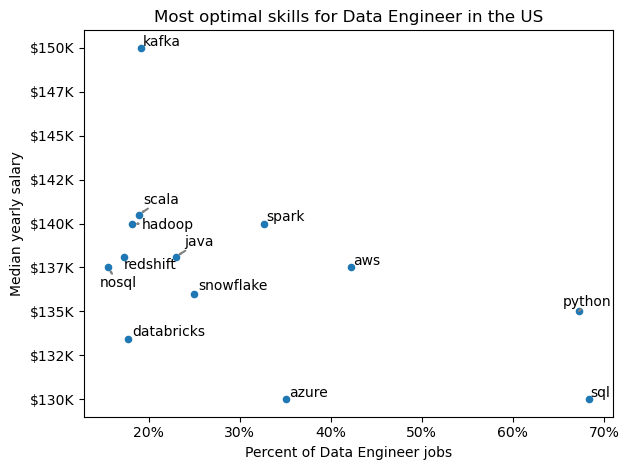

In [7]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter  

df_US_DE_skills_HD.plot(kind='scatter', x='skill_perc', y='median_salary')

texts = []
for i, txt in enumerate(df_US_DE_skills_HD.index):
    texts.append(plt.text(df_US_DE_skills_HD['skill_perc'].iloc[i], df_US_DE_skills_HD['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax =plt.gca()  
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.ylabel('Median yearly salary')
plt.xlabel(f'Percent of {role} jobs')
plt.title(f'Most optimal skills for {role} in the US')
plt.tight_layout()
plt.show()

Lo siguiente es opcional pero muy importante saberlo para la grafica


In [8]:
# Este codigo es para desenredar la columna de 'job_skill_type' que es un diccionario
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [9]:
# Se convierte el diccionario gigante en un DataFrame
df_technology_DF = pd.DataFrame(list(technology_dict.items()), columns=['technology','skills'])
df_technology_DF = df_technology_DF.explode('skills')
df_technology_DF

technology      skills
0   analyst_tools   ms access
0   analyst_tools         sap
0   analyst_tools        spss
0   analyst_tools    esquisse
0   analyst_tools        ssrs
..            ...         ...
9            sync       webex
9            sync    symphony
9            sync  mattermost
9            sync       unify
9            sync        wire

[259 rows x 2 columns]

In [10]:
# Usamos merge para unir los dos dataframes, el creado con los filtros y el creado por el diccionario
df_plot = df_US_DE_skills_HD.merge(df_technology_DF, left_on='job_skills', right_on='skills')
df_plot

skill_count  median_salary  skill_perc   technology      skills
0          5324      129999.75   68.326489  programming         sql
1          5238      135000.00   67.222793  programming      python
2          3292      137500.00   42.248460        cloud         aws
3          2738      130000.00   35.138604        cloud       azure
4          2544      140000.00   32.648871    libraries       spark
5          1943      136000.00   24.935832        cloud   snowflake
6          1789      138100.00   22.959446  programming        java
7          1492      150000.00   19.147844    libraries       kafka
8          1473      140500.00   18.904004  programming       scala
9          1419      140000.00   18.210986    libraries      hadoop
10         1383      133400.00   17.748973        cloud  databricks
11         1348      138100.00   17.299795        cloud    redshift
12         1211      137500.00   15.541581  programming       nosql

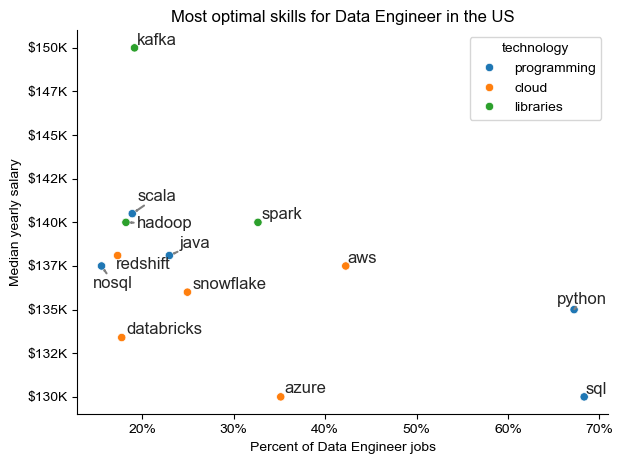

In [11]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter  

# df_plot.plot(kind='scatter', x='skill_perc', y='median_salary')
sns.scatterplot(df_plot, x='skill_perc', y='median_salary', hue='technology')
sns.despine()
sns.set_theme(style='ticks')

texts = []
for i, txt in enumerate(df_US_DE_skills_HD.index):
    texts.append(plt.text(df_US_DE_skills_HD['skill_perc'].iloc[i], df_US_DE_skills_HD['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax =plt.gca()  
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.ylabel('Median yearly salary')
plt.xlabel(f'Percent of {role} jobs')
plt.title(f'Most optimal skills for {role} in the US')
plt.tight_layout()
plt.show()